In [1]:
%pwd

In [46]:
import sys, os
import pandas as pd
import numpy as np
from datetime import datetime
from pymongo import MongoClient

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.spatial.distance import mahalanobis

import matplotlib.pyplot as plt
import seaborn as sns

from api.clustering import *

In [13]:
year = 2017
uri = "mongodb://mongo/tweets"
client = MongoClient(uri)

# database
db = client['irs990']

# collection
dbYear = db['%s' % year]

In [14]:
# get the columns used for financial clustering
with open('../config/columns.csv') as fin_columns_csv:
    fin_columns = fin_columns_csv.read().split(',\n')

# transform columns into dictionary for mongo cursor query
find_fin_cols = {}
for column_name in fin_columns:
    find_fin_cols[column_name] = 1
    
#execute query against all columns
cursor = dbYear.find({},find_fin_cols)

In [15]:
df_original = pd.DataFrame(list(cursor))

# for each column, rename without /IRS990/ in the front
clean_cols = {}
for col in fin_columns:
    if col.startswith('/IRS990EZ/'):
        clean_cols[col] = col.replace('/IRS990EZ/','')
    elif col.startswith('/IRS990'):
        clean_cols[col] = col.replace('/IRS990/','')
    else:
        clean_cols[col] = col
        
df_original = df_original.rename(columns=clean_cols)
df_original['EIN'] = df_original['EIN'].apply(pd.to_numeric, errors='ignore')

In [16]:
'''
Read, clean, and separate data by form type.
'''
# df_original = pd.read_csv('../../capstone-data/sample_data_2017_M4_v3.csv', 
#                  dtype= {'FormationYr':'object'},
#                  low_memory=False)
# df_original = df_original.drop(['ActivityOrMissionDesc'
#               , 'BooksInCareOfDetail/USAddress/ZIPCode'
#               , 'PrincipalOfficerNm'
#               , 'Desc'
#               , 'MissionDesc'
#               , 'PrimaryExemptPurposeTxt'
#               , 'OrganizationName'
#               , 'URL'
#               , 'WebsiteAddressTxt'
#               , '_id'
#               , 'EmployeeCnt' # dupe of TotalEmployeeCnt
#               , 'NetAssetsOrFundBalancesEOYAmt' #dupe of TotalNetAssetsFundBalanceGrp/EOYAmt (990) and NetAssetsFundBalanceGrp/EOYAmt (EZ)
# #               , 'TaxExemptBondsInd'
# #               , 'TotLiabNetAssetsFundBalanceGrp/EOYAmt' # sum of TotalLiabilitiesGrp/EOYAmt and TotalNetAssetsFundBalanceGrp/EOYAmt
#               , 'TotalAssetsGrp/EOYAmt' # dupe of TotLiabNetAssetsFundBalanceGrp/EOYAmt
#               , 'TotalAssetsGrp/BOYAmt'
#               , 'NoListedPersonsCompensatedInd'
#               , 'TaxPeriod'
#              ], axis =1)

df_990 = df_original[df_original['FormType'] == '990']
df_990 = df_990.drop(['FormType'], axis = 1)
df_990 = df_990.dropna(how = "all", axis = 1)
df_990 = df_990.fillna(0)
df_990.reset_index(inplace=True, drop = True)
df_990 = df_990.apply(pd.to_numeric, errors='ignore')

df_990EZ = df_original[df_original['FormType'] == '990EZ']
df_990EZ = df_990EZ.drop(['FormType'], axis = 1)
df_990EZ = df_990EZ.dropna(how = "all", axis = 1)
df_990EZ = df_990EZ.fillna(0)
df_990EZ.reset_index(inplace=True, drop = True)
df_990EZ = df_990EZ.apply(pd.to_numeric, errors='ignore')

### Form 990 Modeling

In [17]:
'''
Data prep & feature engineering
'''

# Functions for cleaning
def replace_infinity(result):
    result = result.fillna(0)
    result = result.replace(np.inf, 1.0)
    result = result.replace(-np.inf, 0.0)
    return result

def calculatePercentChange(series1, series2):
    result = (series1-series2)/series1
    return replace_infinity(result)

def scaleColumns(df, cols_to_scale, scaler):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df



# Transform required boolean columns to binary
df_990['ScheduleBRequiredInd'] = df_990['ScheduleBRequiredInd'].replace('false', 0).replace('true', 1).replace('0', 0).replace('1', 1).astype('int64')
df_990['TaxExemptBondsInd'] = df_990['TaxExemptBondsInd'].replace('false', 0).replace('true', 1).replace('0', 0).replace('1', 1).astype('int64')

# Related Org binary
df_990['RelatedOrg'] = df_990['RelatedOrganizationsAmt'].apply(lambda row: 1 if row != 0 else row)

# Transform formation year into age calcualtion
df_990['FormationYr'] = df_990['FormationYr'].astype('int64')
now = datetime.now()

# Age is current year minus formation year, else 0
df_990['FilerAge'] = df_990['FormationYr'].apply(lambda x: now.year-x if x != 0 else 0)

# TotalContributionsAmt divided by RevenueAmt
df_990['TotalContribRatio'] = df_990['TotalContributionsAmt']/df_990['RevenueAmt']
df_990['TotalContribRatio'] = replace_infinity(df_990['TotalContribRatio'])

# ProgramServicesAmt divided by TotalAmt
df_990['ProgramServicesRatio'] = df_990['TotalFunctionalExpensesGrp/ProgramServicesAmt']/df_990['TotalFunctionalExpensesGrp/TotalAmt']
df_990['ProgramServicesRatio'] = replace_infinity(df_990['ProgramServicesRatio'])

# ManagementAndGeneralAmt divided by TotalAmt
df_990['ManagementExpRatio'] = df_990['TotalFunctionalExpensesGrp/ManagementAndGeneralAmt']/df_990['TotalFunctionalExpensesGrp/TotalAmt']
df_990['ManagementExpRatio'] = replace_infinity(df_990['ManagementExpRatio'])

# FundraisingAmt divided by TotalAmt
df_990['FundraisingRatio'] = df_990['TotalFunctionalExpensesGrp/FundraisingAmt']/df_990['TotalFunctionalExpensesGrp/TotalAmt']
df_990['FundraisingRatio'] = replace_infinity(df_990['FundraisingRatio'])

# % Change of Assets over the year
# df_990['PercentTotalAsstChng'] = calculatePercentChange(df_990['TotalAssetsGrp/BOYAmt'], df_990['TotalAssetsGrp/EOYAmt'])
df_990['PercentFundBalChng'] = calculatePercentChange(df_990['TotLiabNetAssetsFundBalanceGrp/BOYAmt']-df_990['TotalLiabilitiesGrp/BOYAmt'], df_990['TotLiabNetAssetsFundBalanceGrp/EOYAmt']-df_990['TotalLiabilitiesGrp/EOYAmt'])
df_990['PercentTotalLiabChng'] = calculatePercentChange(df_990['TotalLiabilitiesGrp/BOYAmt'], df_990['TotalLiabilitiesGrp/EOYAmt'])

# % Change Previous Year to Current Year
df_990['PercentSalaryChng'] = calculatePercentChange(df_990['PYSalariesCompEmpBnftPaidAmt'], df_990['CYSalariesCompEmpBnftPaidAmt'])
df_990['PercentTotalExpenseChng'] = calculatePercentChange(df_990['PYTotalExpensesAmt'], df_990['CYTotalExpensesAmt'])
df_990['PercentProfFndrsngExpnsChng'] = calculatePercentChange(df_990['PYTotalProfFndrsngExpnsAmt'], df_990['CYTotalProfFndrsngExpnsAmt'])
df_990['PercentRevenueChng'] = calculatePercentChange(df_990['PYTotalRevenueAmt'], df_990['CYTotalRevenueAmt'])

# Drop Columnsn
df_990 = df_990.drop(columns=['FormationYr',
                      'TotalContributionsAmt',
                      'TotalFunctionalExpensesGrp/ProgramServicesAmt',
                      'TotalFunctionalExpensesGrp/ManagementAndGeneralAmt',
                      'TotalFunctionalExpensesGrp/FundraisingAmt',
#                       'TotalAssetsGrp/BOYAmt',
                      'TotLiabNetAssetsFundBalanceGrp/BOYAmt',
                      'TotLiabNetAssetsFundBalanceGrp/EOYAmt',
                      'TotalLiabilitiesGrp/BOYAmt',
                      'RelatedOrganizationsAmt',
                      'CYSalariesCompEmpBnftPaidAmt',
                      'CYTotalExpensesAmt',
                      'CYTotalProfFndrsngExpnsAmt',
                      'CYTotalRevenueAmt',
                      'PYSalariesCompEmpBnftPaidAmt',
                      'PYTotalExpensesAmt',
                      'PYTotalProfFndrsngExpnsAmt',
                      'PYTotalRevenueAmt'      
                     ])

# Scale columns where it makes sense to
cols = df_990.columns
set_cols = set(cols)
cols_not_scale = ['EIN', 
                  'FilerAge',
                  'TotalContribRatio',
                  'ProgramServicesRatio',
                  'FundraisingRatio',
                  'ManagementExpRatio',
                  'PercentFundBalChng',
#                   'PercentTotalAsstChng',
                  'PercentTotalLiabChng',
                  'PercentSalaryChng',
                  'PercentTotalExpenseChng',
                  'PercentProfFndrsngExpnsChng',
                  'PercentRevenueChng',
                  'RelatedOrg',
                  'ScheduleBRequiredInd',
                  'TaxExemptBondsInd'
                 ]

for col in cols_not_scale:
    set_cols.remove(col)
    
scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()

df_990 = scaleColumns(df_990, list(set_cols), min_max_scaler)

[0.74102963 0.9630771  0.99388733 0.99867547 0.99990074 0.99992422
 0.99994004 0.99995252 0.99996317 0.99997091 0.99997721 0.99998227
 0.99998682 0.99999028 0.99999311 0.99999497 0.99999635 0.99999755
 0.99999837 0.99999911 0.99999961 0.99999994 0.99999998 1.
 1.         1.        ]


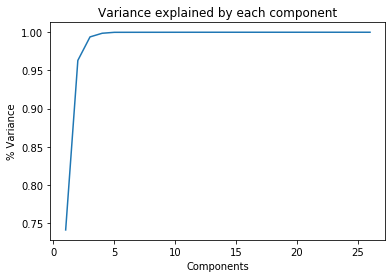

In [18]:
'''
Dimensionality reduction with PCA
'''

# Helper functions
def PCA_components(df):
    pca = PCA()
    pca.fit(df.loc[:, df.columns != 'EIN'])
    df_pca = pca.transform(df.loc[:, df.columns != 'EIN'])
    var = pca.explained_variance_ratio_
    var_cumsum = np.cumsum(var)
    comp = range(1, len(var)+1)

    %matplotlib inline
    plt.plot(comp,var_cumsum)
    plt.xlabel('Components')
    plt.ylabel('% Variance')
    plt.title('Variance explained by each component')
    print(var_cumsum)

def fit_pca(df, n):
    eins = list(df['EIN'])
    pca = PCA(n_components = n)
    pca.fit(df.loc[:, df.columns != 'EIN'])
    df_pca = pca.transform(df.loc[:, df.columns != 'EIN'])
    df_pca = pd.DataFrame(df_pca)
    df_pca['EIN'] = eins
    return df_pca

PCA_components(df_990)
df_990_reduced = fit_pca(df_990, 5)

In [19]:
'''
Hierarchical clustering using clustering.py script
'''
X = df_990_reduced.loc[:, df_990_reduced.columns != 'EIN'].values

'''
Z is linkage matrix
gap_metrics is dictionary of ks, logWs, logBWs, and stderr values
bc is best number of clusters
clusters are labels
'''
Z, gap_metrics, bc, clusters_990 = create_clusters(X, C = 500)

df_990['labels'] = clusters_990
# df_990.groupby(['labels']).count()['EIN']

Scanning: 10
Scanning: 20
Scanning: 30
Scanning: 40
Scanning: 50
Scanning: 60
Scanning: 70
Scanning: 80
Scanning: 90
Scanning: 100
Scanning: 110
Scanning: 120
Scanning: 130
Scanning: 140
Scanning: 150
Scanning: 160
Scanning: 170
Scanning: 180
Scanning: 190
Scanning: 200
Scanning: 210
Scanning: 220
Scanning: 230
Scanning: 240
Scanning: 250
Scanning: 260
Scanning: 270
Scanning: 280
Scanning: 290
Scanning: 300
Scanning: 310
Scanning: 320
Scanning: 330
Scanning: 340
Scanning: 350
Scanning: 360
Scanning: 370
Scanning: 380
Scanning: 390
Scanning: 400
Scanning: 410
Scanning: 420
Scanning: 430
Scanning: 440
Scanning: 450
Scanning: 460
Scanning: 470
Scanning: 480
Scanning: 490
Scanning: 500

Cluster sizes: [ 14  20  22  24  29  30  31  32  34  36  37  38  39  40  42  43  44  45
  47  48  49  50  52  54  55  56  57  58  59  61  62  65  67  68  69  71
  72  73  74  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109
 

### Form 990EZ Modeling

In [20]:
'''
Data prep & feature engineering
'''

# Calculate Total Liabilities column
df_990EZ['TotalLiabilitiesGrp/EOYAmt'] = df_990EZ['Form990TotalAssetsGrp/EOYAmt'] - df_990EZ['NetAssetsOrFundBalancesGrp/EOYAmt']
df_990EZ = df_990EZ.drop(columns=['Form990TotalAssetsGrp/EOYAmt'])

# Scale columns where it makes sense to
cols = df_990EZ.columns
set_cols = set(cols)
cols_not_scale = ['EIN']

for col in cols_not_scale:
    set_cols.remove(col)
    
scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()

df_990EZ = scaleColumns(df_990EZ, list(set_cols), min_max_scaler)

In [22]:
'''
Hierarchical clustering using clustering.py script
'''
X = df_990EZ.loc[:, df_990EZ.columns != 'EIN'].values

'''
Z is linkage matrix
gap_metrics is dictionary of ks, logWs, logBWs, and stderr values
bc is best number of clusters
clusters are labels
'''
Z, gap_metrics, bc, clusters_990EZ = create_clusters(X, C = 500)

df_990EZ['labels'] = clusters_990EZ
# df_990EZ.groupby(['labels']).count()['EIN']

Scanning: 10
Scanning: 20
Scanning: 30
Scanning: 40
Scanning: 50
Scanning: 60
Scanning: 70
Scanning: 80
Scanning: 90
Scanning: 100
Scanning: 110
Scanning: 120
Scanning: 130
Scanning: 140
Scanning: 150
Scanning: 160
Scanning: 170
Scanning: 180
Scanning: 190
Scanning: 200
Scanning: 210
Scanning: 220
Scanning: 230
Scanning: 240
Scanning: 250
Scanning: 260
Scanning: 270
Scanning: 280
Scanning: 290
Scanning: 300
Scanning: 310
Scanning: 320
Scanning: 330
Scanning: 340
Scanning: 350
Scanning: 360
Scanning: 370
Scanning: 380
Scanning: 390
Scanning: 400
Scanning: 410
Scanning: 420
Scanning: 430
Scanning: 440
Scanning: 450
Scanning: 460
Scanning: 470
Scanning: 480
Scanning: 490
Scanning: 500

Cluster sizes: [ 15  19  20  23  27  31  32  34  37  39  41  43  45  46  47  49  50  51
  52  54  55  56  57  58  59  61  63  65  66  67  68  69  70  72  74  75
  76  78  80  81  83  84  85  86  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 

In [23]:
df_990EZ.dtypes

NetAssetsOrFundBalancesGrp/EOYAmt    float64
TotalRevenueAmt                      float64
EIN                                    int64
_id                                  float64
TotalLiabilitiesGrp/EOYAmt           float64
labels                                 int32
dtype: object

In [24]:
df_990.dtypes

GovernmentGrantsAmt                    float64
GrossReceiptsAmt                       float64
OtherSalariesAndWagesGrp/TotalAmt      float64
RevenueAmt                             float64
ScheduleBRequiredInd                     int64
TaxExemptBondsInd                        int64
TotalEmployeeCnt                       float64
TotalFunctionalExpensesGrp/TotalAmt    float64
TotalLiabilitiesGrp/EOYAmt             float64
TotalNetAssetsFundBalanceGrp/EOYAmt    float64
TotalProgramServiceRevenueAmt          float64
TotalReportableCompFromOrgAmt          float64
TotalVolunteersCnt                     float64
EIN                                      int64
_id                                    float64
RelatedOrg                               int64
FilerAge                                 int64
TotalContribRatio                      float64
ProgramServicesRatio                   float64
ManagementExpRatio                     float64
FundraisingRatio                       float64
PercentFundBa

In [25]:
df_original.dtypes

CYSalariesCompEmpBnftPaidAmt                          object
CYTotalExpensesAmt                                    object
CYTotalProfFndrsngExpnsAmt                            object
CYTotalRevenueAmt                                     object
FormationYr                                           object
GovernmentGrantsAmt                                   object
GrossReceiptsAmt                                      object
OtherSalariesAndWagesGrp/TotalAmt                     object
PYSalariesCompEmpBnftPaidAmt                          object
PYTotalExpensesAmt                                    object
PYTotalProfFndrsngExpnsAmt                            object
PYTotalRevenueAmt                                     object
RelatedOrganizationsAmt                               object
RevenueAmt                                            object
ScheduleBRequiredInd                                  object
TaxExemptBondsInd                                     object
TotLiabNetAssetsFundBala

### Merge cluster results

In [26]:
'''
Combine original data sets and re-scale
'''

df_all = df_original[['EIN', 'GrossReceiptsAmt']]
df_all = df_all.fillna(0)
df_all = scaleColumns(df_all, ['GrossReceiptsAmt'], min_max_scaler)
df_all = df_all.merge(df_990[['EIN', 'labels']], how = 'left', on = 'EIN')
df_all = df_all.merge(df_990EZ[['EIN', 'labels']], how = 'left', on = 'EIN')
df_all = df_all.rename(index=str, columns = {'labels_x': 'labels_990', 'labels_y': 'labels_EZ'})


'''
Find the means of GrossReceiptAmt for each cluster
'''
means990 = df_all[~df_all['labels_990'].isna()]
means990 = pd.DataFrame(means990.groupby(['labels_990']).mean()['GrossReceiptsAmt'])
means990.reset_index(inplace = True)
x990 = means990.values

meansEZ = df_all[~df_all['labels_EZ'].isna()]
meansEZ = pd.DataFrame(meansEZ.groupby(['labels_EZ']).mean()['GrossReceiptsAmt'])
meansEZ.reset_index(inplace = True)
xEZ = meansEZ.values


'''
Calculate similarity scores based on cluster means 
1 row per EZ cluster, 1 col per 990 cluster
'''
similarity_scores = euclidean_distances(xEZ[:,1:], x990[:,1:])


'''
Creates column for the min sim score (i.e. closest match) and position of closest cluster
'''
min_distance = []
position = []
for row in similarity_scores:
    min_distance.append(min(row))
    position.append(min(enumerate(row),key=lambda x: x[1])[0])

meansEZ['min_distance'] = min_distance
meansEZ['position'] = position


'''
Bring in means990 data for closest cluster
'''
combined_clusters = meansEZ.merge(means990, how = 'left', left_on = 'position', right_index = True)
combined_clusters = combined_clusters.rename(index=str, columns = {'GrossReceiptsAmt_y': 'GrossReceiptsAmt_990', 'GrossReceiptsAmt_x': 'GrossReceiptsAmt_EZ'})


'''
If min distance < threshold, merge clusters, otherwise keep create new cluster
'''
threshold = .000001
new_cluster_id = max(df_990['labels'])
final_labels = []
for i in combined_clusters.index:
    if combined_clusters.loc[i, 'min_distance'] < threshold:
        final_labels.append(combined_clusters.loc[i, 'labels_990'])
    else:
        new_cluster_id += 1
        final_labels.append(new_cluster_id)
combined_clusters['final_labels'] = [int(x) for x in final_labels]
combined_clusters['labels_EZ'] = combined_clusters['labels_EZ'].astype('int64')


'''
Add final_label to df_990EZ dataframe
'''
df_990EZ = df_990EZ.merge(combined_clusters[['labels_EZ', 'final_labels']], how = 'left', left_on = 'labels', right_on = 'labels_EZ')
df_990EZ = df_990EZ.drop(['labels', 'labels_EZ'], axis = 1)
df_990EZ = df_990EZ.rename(index = str, columns = {'final_labels': 'labels'})

'''
Final dataframe with labels
'''
df_original = df_original.merge(df_990[['EIN', 'labels']], how = 'left', on = 'EIN')
df_original = df_original.merge(df_990EZ[['EIN', 'labels']], how = 'left', on = 'EIN')
df_original['labels'] = df_original['labels_x'].combine_first(df_original['labels_y'])
df_original = df_original.drop(['labels_x', 'labels_y'], axis = 1)

# if we have any inf or na clusters, we assign cluster id 999
df_original['labels'] = df_original['labels'].apply(lambda x: 999 if np.isnan(x) else x)

df_original['labels'] = df_original['labels'].astype('int64')

In [27]:
# df_original.to_csv('./labels_M7.csv', index = False)

In [28]:
# def scaleColumns(df, cols_to_scale, scaler):
#     for col in cols_to_scale:
#         df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
#     return df
# min_max_scaler = preprocessing.MinMaxScaler()

In [29]:
'''
Data for variance visualization (Tableau)
'''

# df_original = pd.read_csv('./labels_M7.csv', dtype = {'FormType': 'object'})
df_final_990 = df_original[df_original['FormType'] == '990']
df_final_990 = df_final_990[['EIN', 'GrossReceiptsAmt', 'RevenueAmt', 'TotalNetAssetsFundBalanceGrp/EOYAmt', 'TotalLiabilitiesGrp/EOYAmt', 'labels']]
df_final_990.columns = ['EIN', 'Gross Receipts', 'Revenue', 'Fund Balance', 'Liabilities', 'labels']

df_final_990EZ = df_original[df_original['FormType'] == '990EZ']
df_final_990EZ['Form990TotalAssetsGrp/EOYAmt'] = df_final_990EZ['Form990TotalAssetsGrp/EOYAmt'].astype('int64')
df_final_990EZ['NetAssetsOrFundBalancesGrp/EOYAmt'] = df_final_990EZ['NetAssetsOrFundBalancesGrp/EOYAmt'].astype('int64')
df_final_990EZ['TotalLiabilitiesGrp/EOYAmt'] = df_final_990EZ['Form990TotalAssetsGrp/EOYAmt'] - df_final_990EZ['NetAssetsOrFundBalancesGrp/EOYAmt']
df_final_990EZ = df_final_990EZ[['EIN', 'GrossReceiptsAmt', 'TotalRevenueAmt', 'NetAssetsOrFundBalancesGrp/EOYAmt', 'TotalLiabilitiesGrp/EOYAmt', 'labels']]
df_final_990EZ.columns = ['EIN', 'Gross Receipts', 'Revenue', 'Fund Balance', 'Liabilities', 'labels']

df_final = df_final_990.append(df_final_990EZ)
df_final = df_final.fillna(0)

cols = list(df_final.columns)[1:-1]
df_final = scaleColumns(df_final, cols, min_max_scaler)
# df_final.to_csv('./var_viz_M7.csv', index = False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [30]:
'''
Calculate distance from cluster center for each org.
'''

cluster_means = pd.DataFrame(df_final.groupby(['labels']).mean()).reset_index()
cluster_means = cluster_means.groupby(['labels']).mean().dropna(how='any')
cluster_means.drop(['EIN'], inplace=True, axis = 1)
cluster_means = cluster_means.values

clusters = set(df_final['labels'])
names = ["distance_" + str(cluster) for cluster in clusters]

'''
Try Euclidean, cosine, and Mahalanobis
'''

for i, row in enumerate(df_final.values):
    for means in cluster_means:
        for cluster in clusters:
            if means[0] == cluster: # check for same cluster label
                x = row[1:-1].reshape([1,4])
                y = means[1:].reshape([1,4])
                df_final.loc[i, names[cluster-1]] = (float(cosine_similarity(x, y)))

In [42]:
# df_final.to_csv('./df_final_M7.csv', index = False)
# df_final.to_csv('./df_final_M8_cosine2.csv', index = False)
df_final.columns


Index(['EIN', 'Gross Receipts', 'Revenue', 'Fund Balance', 'Liabilities',
       'labels'],
      dtype='object')

In [ ]:
df_final = df_final.dropna(how='any')

# TODO: save to db

In [50]:
for key, row in df_final.iterrows():
    ein = str(int(row['EIN']))
    data = row[['Gross Receipts', 'Revenue', 'Fund Balance', 'Liabilities', 'labels']].to_dict()
    sys.stdout.write(  'Save values for %s \r' % ein )
    
    try:
        dbYear.update_one( {"EIN" : ein}, {"$set":data}, upsert=True )
    except Exception as e:
        sys.stdout.write( 'ERROR: Problem during MongoDB insert. %s' % e )
        
    sys.stdout.flush()